# Лабораторная работа 6: Машина опорных векторов (SVM)

<img src="svm_img.png" width=350>

Результат лабораторной работы — **отчет** в формате ноутбуков IPython (ipynb-файл). Нам не интересен ваш код. Чем меньше кода, тем лучше всем: нам — меньше проверять, вам — проще найти ошибку или дополнить эксперимент.

Постарайтесь сделать ваш отчет интересным рассказом, последовательно отвечающим на вопросы из заданий. Ответы на вопросы должны быть полными, четкими и хорошо аргументированными.

## 1. Квадратичное программирование и QP-солвер

Квадратичное программирование (QP) — специальный тип задач математической оптимизации, заключающийся в нахождении точки минимума неотрицательно-определенной квадратичной формы (многомерная парабола) в присутствии линейных ограничений:
$$
\begin{gather}
    \frac{1}{2}\boldsymbol x^T\boldsymbol P\boldsymbol x + \boldsymbol q^T\boldsymbol x \to \min_{\boldsymbol x} \\
    \begin{aligned}
        \text{s.t.} \quad & \boldsymbol G\boldsymbol x \le \boldsymbol h \\
        & \boldsymbol A\boldsymbol x = \boldsymbol b
    \end{aligned}
\end{gather}
$$

Здесь $\boldsymbol P$ — симметричная матрица. В ограничениях $\boldsymbol G\boldsymbol x \le \boldsymbol h$ и $\boldsymbol A\boldsymbol x = \boldsymbol b$ под знаками равенства и неравенства подразумевается сравнение всех компонент векторов.

Задача квадратичного программирования хорошо изучена, существуют эффективные алгоритмы для ее решения. Имеется множество библиотек с солверами для задачи QP, вот некоторые из них:
 - [CVXOPT](http://cvxopt.org/) (свободно-распространяемая, Python) **рекомендуется к использованию**
 - [Mosek](https://www.mosek.com/) (коммерческая с возможностью получения академической лицензии, C, Java, MATLAB, .NET, R, Python)
 - [Matlab Optimization Toolbox](http://www.mathworks.com/help/optim/ug/quadprog.html)

#### Задание

1. Установите QP-солвер, разберитесь с его интерфейсом.
2. Протестируйте солвер, решив простую задачу оптимизации в двумерном пространстве:
$$f(\boldsymbol x) = -8x_1 - 16x_2 + x_1^2 + 4x_2^2, \quad \text{s.t.:} \; x_1 + x_2 \leq 5, \; 0 \leq x_1 \leq 3, \; x_2 \geq 0$$
3. Какие из ограничений-неравенств задачи являются _активными_, т.е. влияют на точку оптимума, а какие ограничения можно выбросить и точка оптимума не поменяется?

In [1]:
!pip install cvxopt

In [2]:
import numpy as np
from cvxopt import solvers, matrix
P = matrix(np.array([[2,0],[0,8.]]), tc="d")
q = matrix(np.array([-8,16.]), tc="d")
G = matrix(np.array([[1,1],[1,0],[-1,0],[0,-1.]]), tc="d")
h = matrix(np.array([5,3,0,0.]), tc="d")
solvers.options['show_progress'] = False
sol = solvers.qp(P,q,G,h)

In [3]:
np.array(sol["x"]), np.array(sol["x"]).dtype

(array([[ 2.99999983e+00],
        [-4.88632525e-09]]),
 dtype('float64'))

## 2. Линейный SVM

Рассмотрим задачу бинарной классификации. Будем обозначать обучающую выборку $\{(\boldsymbol x_n, y_n)\}_{n=1}^N$, где $N$ — количество объектов, $\boldsymbol x_n \in \mathbb{R}^d$ — числовой вектор признакового описания объекта, $y_n \in \{+1, -1\}$ — класс объекта.

Машина опорных векторов обучает модель разделяющей гиперплоскости:
$$f(\boldsymbol x) = \boldsymbol w^T \boldsymbol x + b$$
Параметры модели — вектор весов $\boldsymbol w \in \mathbb{R}^d$ и сдвиг $b \in \mathbb{R}$.

Обучение модели происходит путем решения оптимизационной задачи:
$$
\begin{gather}
    \frac{1}{2} \| \boldsymbol w \|^2 + C \sum_{n=1}^N \xi_n \to \min_{\boldsymbol w, \boldsymbol \xi, b} \\
    \text{s.t.: } \quad y_n (\boldsymbol w^T \boldsymbol x_n + b) \geq 1 - \xi_n, \quad \xi_n \geq 0, \quad \forall n=1,\dots,N
\end{gather}
$$

Ограничения вида $\quad y_n (\boldsymbol w^T \boldsymbol x_n + b) \geq 1$ требуют, чтобы объекты правильно классифицировались разделяющей гиперплоскостью. Поскольку линейная разделимость выборки не гарантируется на практике, вводят переменные $\xi_n$ (slack variables), которые ослабляют ограничения правильной классификации. В оптимизируемом функционале слагаемое $\| \boldsymbol w \|^2$ штрафует малую ширину разделяющей гиперплоскости, сумма $\sum_n \xi_n$ штрафует ослабление ограничений.

Гиперпараметр $C$ задает баланс между шириной разделяющей полосы и ошибками, допускаемыми классификатором. Обратите внимание, что $C$ фиксируется до обучения и не оптимизируется вместе с параметрами модели.

Гиперпараметр $C$ отвечает за обобщающую способность разделяющей гиперплоскости, высокая обобщающая способность (соотвествующая большому значению $C$) может привести к переобучению, если линейная модель хорошо описывает обучающие примеры. При подборе оптимального параметра $C$ необходимо оценивать качество на отложенной выборке или кросс-валидации. Как правило, для конкретной задачи заранее неизвестно, какой порядок имеет оптимальное значение гиперпараметра $C$, поэтому перебирать значения лучше по логарифмической сетке, например: $10^{-3}, 10^{-2}, \dots, 10^{5}$.

После нахождения решения оптимизационной задачи $(\boldsymbol w_{\star}, \boldsymbol \xi_{\star}, b_{\star})$, часть ограничений становятся _активными_, т.е. переходят в "крайнее положение" — точное равенство:
$$\quad y_n (\boldsymbol w_{\star}^T \boldsymbol x_n + b_{\star}) = 1 - \xi_{\star,n}$$
Объекты, соответствующие активным ограничениям называются _опорными_.

#### Явное преобразование признаков

Разделяющая гиперплоскость — достаточно грубая модель, редко данные могут быть описаны линейной моделью. Линейная неразделимость векторов может быть исправлена путем перехода в другое признаковое пространство, в котором линейная модель лучше описывает данные и, возможно, существует правильно классифицирующая разделяющая гиперплоскость:

$$\boldsymbol x \in \mathbb{R}^d \mapsto \phi(\boldsymbol x) \in \mathbb{R}^t$$

Так, например, добавление всех попарных произведений признаков: $\phi(x_1, \dots, x_d) = (x_1, \dots, x_d, x_1^2, x_1x_2, \dots, x_d^2)$ переводит в пространство, в котором линейная гиперплоскость является квадратичной формой в исходном пространстве и в исходном пространстве признаков разделяющая поверхность может быть, скажем, эллипсом.

[Видеоролик с демонстрацией](https://youtu.be/9NrALgHFwTo)

#### Задание
  1. Сведите задачу обучения линейного SVM к QP, реализуйте процедуру обучения Линейного SVM при помощи QP-солвера.
  2. Сгенерируйте три случайные двумерные выборки для бинарной классификации:
    - с линейно-разделимыми классами
    - с хорошо разделимыми классами, но не линейно
    - с плохо разделимыми классами по имеющимся признакам
  3. Протестируйте линейный SVM на сгенерированных выборках. Покажите на плоскости разделяющую прямую и линии уровня, ограничивающие коридор $f(\boldsymbol x) = \pm 1$. Выделите опорные вектора точками другой формы или большего размера. Постройте классификаторы с различным значением параметра $C$.
  4. Как зависит число опорных векторов от параметра $C$ для различных выборок?
  5. Используя явное преобразование признаков обучите методом опорных векторов квадратичную разделяющую поверхность. Покажите ее на плоскости.

In [ ]:
d = 3
N = 5
y = np.array([-1,1,1,1,-1])
X = np.random.randint(1,100, size = (N,d))
G = np.block([[-y[:,None] * X, -y[:,None], -np.eye(N)],
             [np.zeros((N,d+1)), -np.eye(N)]])
G = matrix(G)
G

<10x9 matrix, tc='d'>

In [ ]:
y[:,None]

array([[-1],
       [ 1],
       [ 1],
       [ 1],
       [-1]])

Сведение задачи обучения линейного SVM к QP
Демонстрация работы Linear SVM с QP-солвером
Параметры обученной модели:
Вектор весов w = [0.50000001 0.50000001]
Смещение b = -3.5000
Количество опорных векторов: 4
Опорные векторы:
[[2 3]
 [3 2]
 [4 5]
 [5 4]]

Предсказания на обучающих данных: [-1. -1. -1. -1.  1.  1.  1.  1.]
Истинные метки: [0 0 0 0 1 1 1 1]
Точность: 100.0%

Тестирование на трех типах выборок с различными C


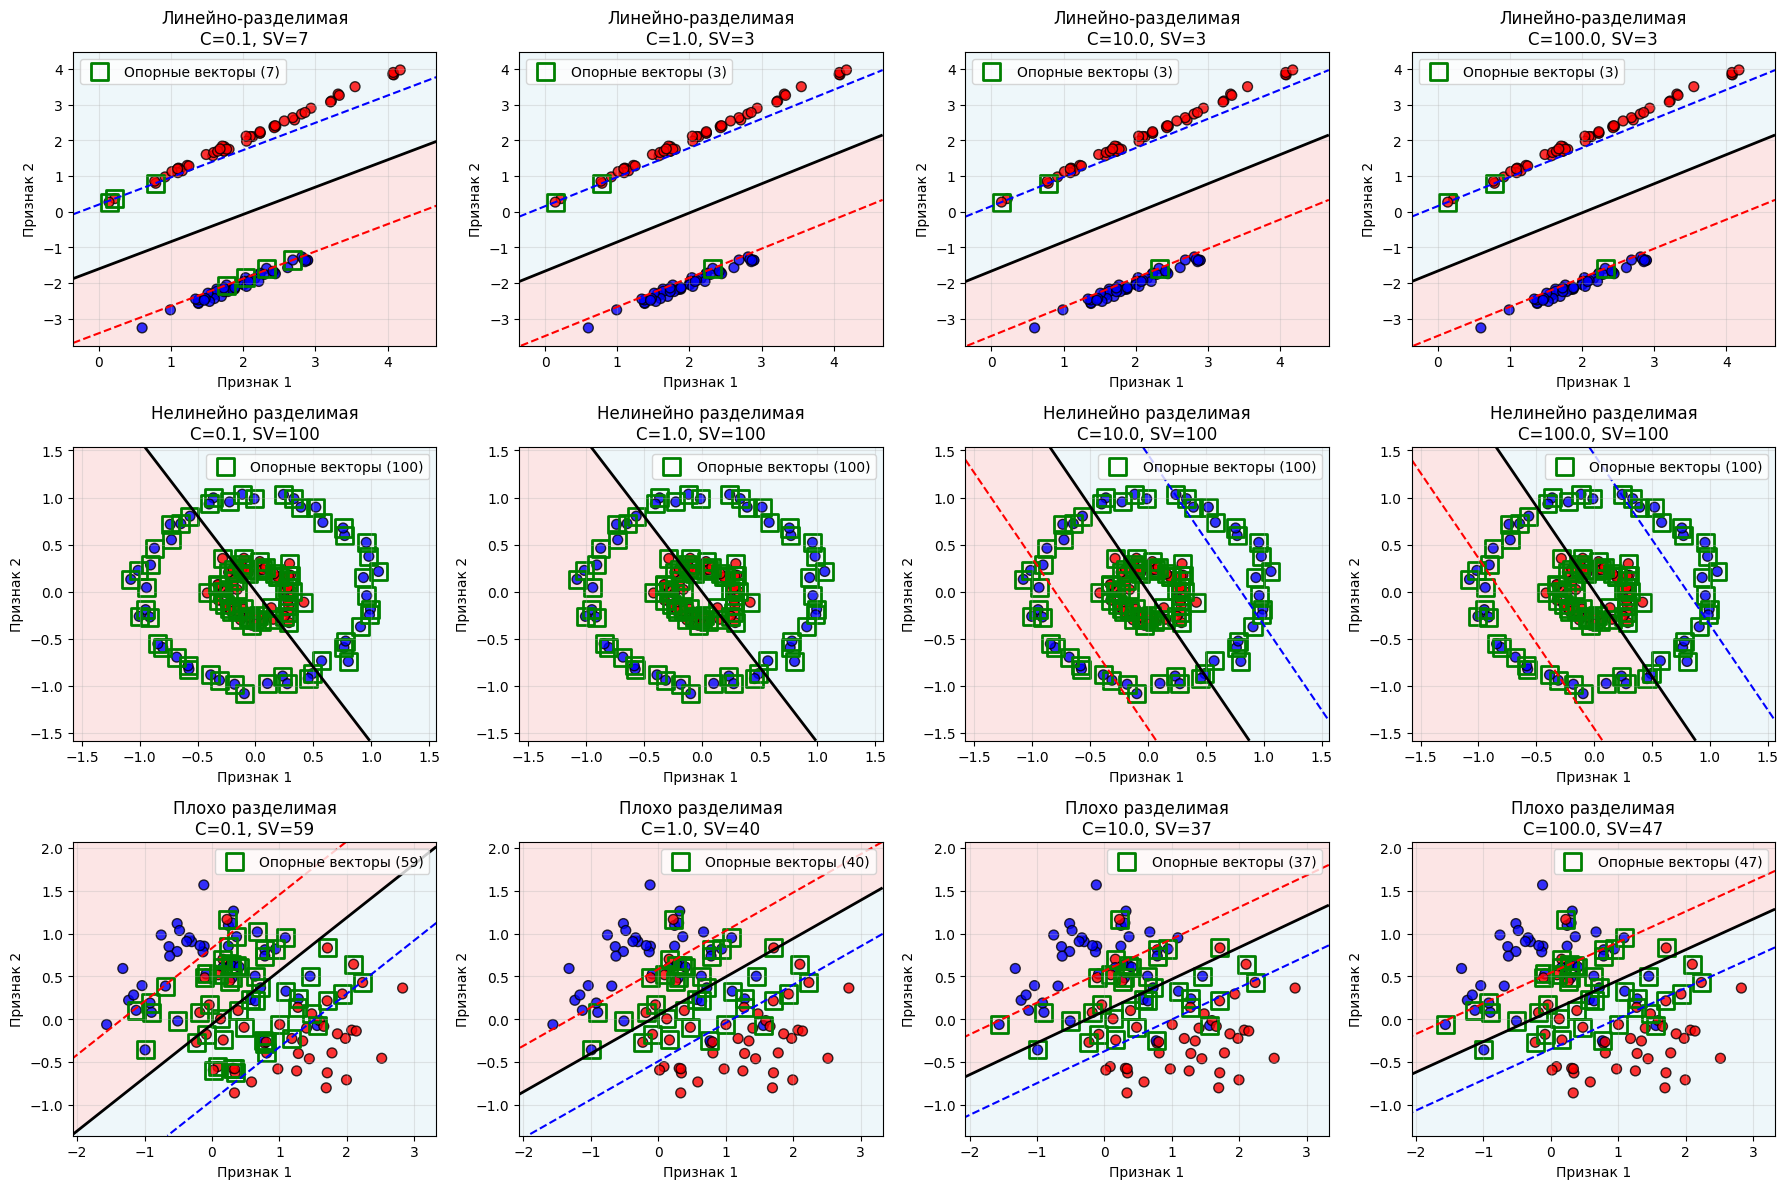

In [7]:
# 1-3
import numpy as np
import matplotlib.pyplot as plt
from cvxopt import matrix, solvers
from sklearn.datasets import make_classification, make_circles, make_moons

# Настройка для подавления вывода QP-солвера
solvers.options['show_progress'] = False

class LinearSVM:
    def __init__(self, C=1.0):
        self.C = C
        self.w = None
        self.b = None
        self.support_vectors = None
        self.support_labels = None

    def fit(self, X, y):
        """
        Обучение линейного SVM сведением к QP задаче
        Двойственная формулировка:
        min 1/2 * α^T * Q * α - 1^T * α
        при 0 ≤ α_i ≤ C
        и y^T * α = 0
        """
        n_samples, n_features = X.shape

        # Преобразуем метки в ±1
        y = y * 2 - 1  # преобразуем 0,1 в -1,1

        # Матрица Q для квадратичной части: Q_ij = y_i * y_j * x_i^T * x_j
        Q = np.outer(y, y) * (X @ X.T)

        # Параметры для QP-солвера
        P = matrix(Q.astype(np.double))  # Матрица для квадратичной части
        q = matrix(-np.ones(n_samples).astype(np.double))  # Вектор для линейной части

        # Ограничения неравенства: -α ≤ 0 и α ≤ C
        G = matrix(np.vstack((-np.eye(n_samples), np.eye(n_samples))))
        h = matrix(np.hstack((np.zeros(n_samples), np.ones(n_samples) * self.C)))

        # Ограничение равенства: sum(y_i * α_i) = 0
        A = matrix(y.astype(np.double).reshape(1, -1))
        b = matrix(0.0)

        # Решение QP задачи
        solution = solvers.qp(P, q, G, h, A, b)

        # Извлечение множителей Лагранжа
        alpha = np.array(solution['x']).flatten()

        # Находим опорные векторы (α > небольшого порога)
        sv_indices = alpha > 1e-5
        self.support_vectors = X[sv_indices]
        self.support_labels = y[sv_indices]
        alpha_sv = alpha[sv_indices]

        # Вычисляем вектор весов w
        self.w = np.sum(alpha_sv[:, np.newaxis] * self.support_labels[:, np.newaxis] *
                       self.support_vectors, axis=0)

        # Вычисляем смещение b
        if len(alpha_sv) > 0:
            margin_sv = self.support_labels - (self.support_vectors @ self.w)
            self.b = np.mean(margin_sv)
        else:
            self.b = 0

        return self

    def predict(self, X):
        """Предсказание меток классов"""
        return np.sign(X @ self.w + self.b)

    def decision_function(self, X):
        """Функция принятия решения f(x) = w^T * x + b"""
        return X @ self.w + self.b

def generate_datasets():
    """
    Генерация трех типов выборок для бинарной классификации:
    1. Линейно-разделимые классы
    2. Хорошо разделимые, но не линейно
    3. Плохо разделимые классы
    """
    np.random.seed(42)

    # 1. Линейно-разделимая выборка
    X_linear, y_linear = make_classification(
        n_samples=100, n_features=2, n_redundant=0, n_informative=2,
        n_clusters_per_class=1, flip_y=0, class_sep=2.0, random_state=42
    )

    # 2. Хорошо разделимая, но не линейно (концентрические круги)
    X_circles, y_circles = make_circles(
        n_samples=100, noise=0.05, factor=0.3, random_state=42
    )

    # 3. Плохо разделимая выборка (перекрывающиеся классы)
    X_moons, y_moons = make_moons(
        n_samples=100, noise=0.3, random_state=42
    )

    datasets = [
        (X_linear, y_linear, "Линейно-разделимая"),
        (X_circles, y_circles, "Нелинейно разделимая"),
        (X_moons, y_moons, "Плохо разделимая")
    ]

    return datasets

def plot_svm_result(X, y, svm, title, ax):
    """
    Визуализация результатов SVM:
    - Разделяющая прямая f(x) = 0
    - Линии уровня f(x) = ±1
    - Опорные векторы
    """
    # Создаем сетку для построения границ
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))

    # Вычисляем функцию решения для сетки
    Z = svm.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Разделяющая прямая (f(x) = 0) и границы зазора (f(x) = ±1)
    ax.contour(xx, yy, Z, levels=[-1, 0, 1],
               colors=['red', 'black', 'blue'],
               linestyles=['--', '-', '--'],
               linewidths=[1.5, 2, 1.5])

    # Заливка областей классов
    ax.contourf(xx, yy, Z, levels=[-np.inf, 0, np.inf],
                alpha=0.2, colors=['lightcoral', 'lightblue'])

    # Отображаем данные
    scatter = ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.bwr,
                        alpha=0.8, edgecolors='k', s=50)

    # Выделяем опорные векторы
    if svm.support_vectors is not None and len(svm.support_vectors) > 0:
        ax.scatter(svm.support_vectors[:, 0], svm.support_vectors[:, 1],
                  s=150, facecolors='none', edgecolors='green',
                  linewidths=2, marker='s',
                  label=f'Опорные векторы ({len(svm.support_vectors)})')
        ax.legend()

    ax.set_title(title, fontsize=12)
    ax.set_xlabel('Признак 1')
    ax.set_ylabel('Признак 2')
    ax.grid(True, alpha=0.3)

def test_svm_on_datasets():
    """Тестирование линейного SVM на трех типах выборок с разными C"""
    datasets = generate_datasets()
    C_values = [0.1, 1.0, 10.0, 100.0]

    # Создаем большую фигуру для всех результатов
    fig, axes = plt.subplots(len(datasets), len(C_values),
                           figsize=(18, 12))

    # Если только одна строка, преобразуем axes в 2D массив
    if len(datasets) == 1:
        axes = axes.reshape(1, -1)

    for i, (X, y, dataset_name) in enumerate(datasets):
        for j, C in enumerate(C_values):
            # Обучаем SVM с текущим значением C
            svm = LinearSVM(C=C)
            svm.fit(X, y)

            # Визуализируем результат
            title = f'{dataset_name}\nC={C}, SV={len(svm.support_vectors)}'
            plot_svm_result(X, y, svm, title, axes[i, j])

    plt.tight_layout()
    plt.show()

def demonstrate_svm_workflow():
    """Демонстрация работы SVM на простом примере"""
    print("Демонстрация работы Linear SVM с QP-солвером")
    print("=" * 50)

    # Простой линейно разделимый пример
    X_simple = np.array([
        [1, 2], [2, 3], [2, 1], [3, 2],  # Класс 0
        [4, 5], [5, 4], [5, 6], [6, 5]   # Класс 1
    ])
    y_simple = np.array([0, 0, 0, 0, 1, 1, 1, 1])

    svm = LinearSVM(C=1.0)
    svm.fit(X_simple, y_simple)

    print("Параметры обученной модели:")
    print(f"Вектор весов w = {svm.w}")
    print(f"Смещение b = {svm.b:.4f}")
    print(f"Количество опорных векторов: {len(svm.support_vectors)}")
    print(f"Опорные векторы:\n{svm.support_vectors}")

    # Предсказания
    predictions = svm.predict(X_simple)
    print(f"\nПредсказания на обучающих данных: {predictions}")
    print(f"Истинные метки: {y_simple}")
    accuracy = np.mean(predictions == (y_simple * 2 - 1))
    print(f"Точность: {accuracy:.1%}")

# Основная программа
if __name__ == "__main__":
    print("Сведение задачи обучения линейного SVM к QP")
    print("=" * 50)

    # Демонстрация на простом примере
    demonstrate_svm_workflow()

    print("\nТестирование на трех типах выборок с различными C")
    print("=" * 50)
    test_svm_on_datasets()

Зависимость числа опорных векторов от параметра C

Линейно-разделимая:
  C=0.01: 40 опорных векторов
  C=0.10:  7 опорных векторов
  C=1.00:  3 опорных векторов
  C=10.00:  3 опорных векторов
  C=100.00:  3 опорных векторов

Нелинейно разделимая:
  C=0.01: 100 опорных векторов
  C=0.10: 100 опорных векторов
  C=1.00: 100 опорных векторов
  C=10.00: 100 опорных векторов
  C=100.00: 100 опорных векторов

Плохо разделимая:
  C=0.01: 98 опорных векторов
  C=0.10: 60 опорных векторов
  C=1.00: 41 опорных векторов
  C=10.00: 42 опорных векторов
  C=100.00: 38 опорных векторов


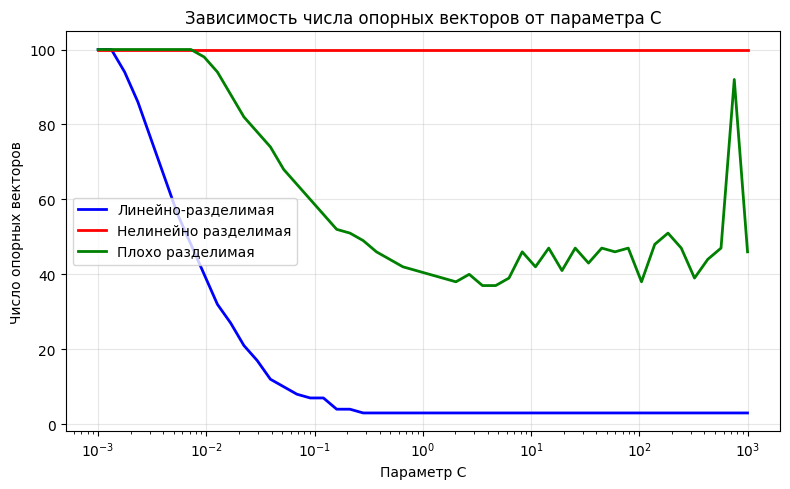

In [10]:
# 3
import numpy as np
import matplotlib.pyplot as plt
from cvxopt import matrix, solvers
from sklearn.datasets import make_classification, make_circles, make_moons

# Настройка для подавления вывода QP-солвера
solvers.options['show_progress'] = False

class LinearSVM:
    def __init__(self, C=1.0):
        self.C = C
        self.w = None
        self.b = None
        self.support_vectors = None

    def fit(self, X, y):
        n_samples, n_features = X.shape

        # Преобразуем метки в ±1
        y = y * 2 - 1

        # Матрица Q для квадратичной части
        Q = np.outer(y, y) * (X @ X.T)

        # Параметры для QP-солвера
        P = matrix(Q.astype(np.double))
        q = matrix(-np.ones(n_samples).astype(np.double))

        # Ограничения неравенства
        G = matrix(np.vstack((-np.eye(n_samples), np.eye(n_samples))))
        h = matrix(np.hstack((np.zeros(n_samples), np.ones(n_samples) * self.C)))

        # Ограничение равенства
        A = matrix(y.astype(np.double).reshape(1, -1))
        b = matrix(0.0)

        # Решение QP задачи
        solution = solvers.qp(P, q, G, h, A, b)

        # Извлечение множителей Лагранжа
        alpha = np.array(solution['x']).flatten()

        # Находим опорные векторы
        sv_indices = alpha > 1e-5
        self.support_vectors = X[sv_indices]

        return self

def generate_datasets():
    """Генерация трех типов выборок"""
    np.random.seed(42)

    # 1. Линейно-разделимая выборка
    X_linear, y_linear = make_classification(
        n_samples=100, n_features=2, n_redundant=0, n_informative=2,
        n_clusters_per_class=1, flip_y=0, class_sep=2.0, random_state=42
    )

    # 2. Хорошо разделимая, но не линейно
    X_circles, y_circles = make_circles(
        n_samples=100, noise=0.05, factor=0.3, random_state=42
    )

    # 3. Плохо разделимая выборка
    X_moons, y_moons = make_moons(
        n_samples=100, noise=0.3, random_state=42
    )

    datasets = [
        (X_linear, y_linear, "Линейно-разделимая"),
        (X_circles, y_circles, "Нелинейно разделимая"),
        (X_moons, y_moons, "Плохо разделимая")
    ]

    return datasets

def analyze_support_vectors_vs_C():
    """Анализ зависимости числа опорных векторов от параметра C"""
    datasets = generate_datasets()

    # Широкий диапазон значений C
    C_values = np.logspace(-3, 3, 50)  # C от 0.001 до 1000

    # Уменьшаем размер графика
    plt.figure(figsize=(8, 5))

    colors = ['blue', 'red', 'green']

    print("Зависимость числа опорных векторов от параметра C")
    print("=" * 50)

    for idx, (X, y, dataset_name) in enumerate(datasets):
        n_support_vectors = []

        for C in C_values:
            svm = LinearSVM(C=C)
            svm.fit(X, y)
            n_support_vectors.append(len(svm.support_vectors))

        # Построение графика (убираем маркеры для уменьшения размера)
        plt.plot(C_values, n_support_vectors,
                color=colors[idx], linewidth=2, label=dataset_name)

        # Вывод статистики для ключевых значений C
        print(f"\n{dataset_name}:")
        key_C_values = [0.01, 0.1, 1.0, 10.0, 100.0]
        for C_val in key_C_values:
            closest_idx = np.argmin(np.abs(C_values - C_val))
            print(f"  C={C_val:.2f}: {n_support_vectors[closest_idx]:2d} опорных векторов")

    # Настройка графика
    plt.xscale('log')
    plt.xlabel('Параметр C')
    plt.ylabel('Число опорных векторов')
    plt.title('Зависимость числа опорных векторов от параметра C')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Запуск анализа
if __name__ == "__main__":
    analyze_support_vectors_vs_C()

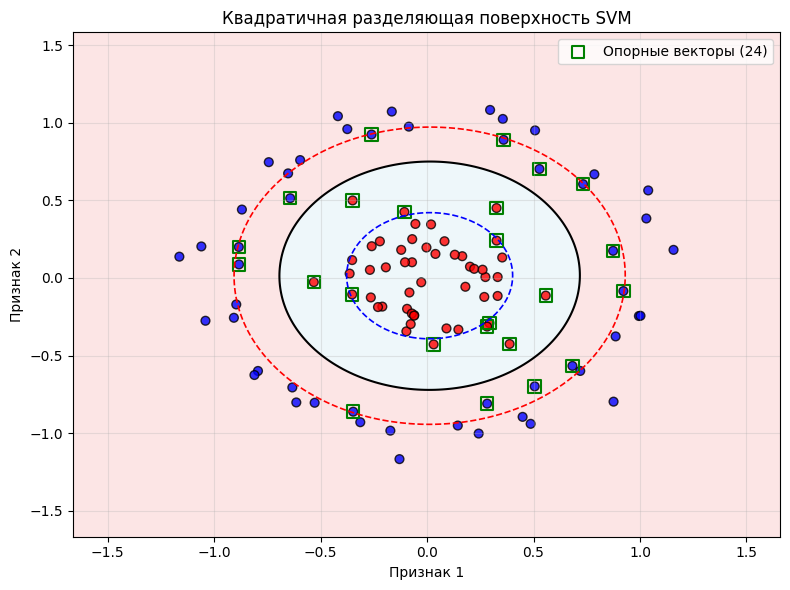

In [13]:
# 4
import numpy as np
import matplotlib.pyplot as plt
from cvxopt import matrix, solvers
from sklearn.datasets import make_circles

# Настройка для подавления вывода QP-солвера
solvers.options['show_progress'] = False

class QuadraticSVM:
    def __init__(self, C=1.0):
        self.C = C
        self.w = None
        self.b = None
        self.support_vectors = None

    def transform_features(self, X):
        """
        Явное преобразование признаков для квадратичной разделяющей поверхности
        [x1, x2] -> [1, x1, x2, x1², x2², x1*x2]
        """
        n_samples = X.shape[0]
        X_transformed = np.ones((n_samples, 6))
        X_transformed[:, 1] = X[:, 0]    # x1
        X_transformed[:, 2] = X[:, 1]    # x2
        X_transformed[:, 3] = X[:, 0]**2 # x1²
        X_transformed[:, 4] = X[:, 1]**2 # x2²
        X_transformed[:, 5] = X[:, 0] * X[:, 1] # x1*x2
        return X_transformed

    def fit(self, X, y):
        """Обучение SVM с квадратичным преобразованием признаков"""
        # Преобразуем признаки
        X_transformed = self.transform_features(X)
        n_samples, n_features = X_transformed.shape

        # Преобразуем метки в ±1
        y_transformed = y * 2 - 1

        # Матрица Q для квадратичной части
        Q = np.outer(y_transformed, y_transformed) * (X_transformed @ X_transformed.T)

        # Параметры для QP-солвера
        P = matrix(Q.astype(np.double))
        q = matrix(-np.ones(n_samples).astype(np.double))

        # Ограничения неравенства
        G = matrix(np.vstack((-np.eye(n_samples), np.eye(n_samples))))
        h = matrix(np.hstack((np.zeros(n_samples), np.ones(n_samples) * self.C)))

        # Ограничение равенства
        A = matrix(y_transformed.astype(np.double).reshape(1, -1))
        b = matrix(0.0)

        # Решение QP задачи
        solution = solvers.qp(P, q, G, h, A, b)

        # Извлечение множителей Лагранжа
        alpha = np.array(solution['x']).flatten()

        # Находим опорные векторы
        sv_indices = alpha > 1e-5
        self.support_vectors = X[sv_indices]
        alpha_sv = alpha[sv_indices]
        y_sv = y_transformed[sv_indices]

        # Вычисляем вектор весов w в преобразованном пространстве
        X_sv_transformed = self.transform_features(self.support_vectors)
        self.w = np.sum(alpha_sv[:, np.newaxis] * y_sv[:, np.newaxis] * X_sv_transformed, axis=0)

        # Вычисляем смещение b
        if len(alpha_sv) > 0:
            self.b = np.mean([
                y_sv[i] - np.dot(self.w, X_sv_transformed[i])
                for i in range(len(alpha_sv))
            ])
        else:
            self.b = 0

        return self

    def decision_function(self, X):
        """Функция принятия решения в преобразованном пространстве"""
        X_transformed = self.transform_features(X)
        return X_transformed @ self.w + self.b

# Генерируем нелинейно разделимые данные (круги)
X, y = make_circles(n_samples=100, noise=0.1, factor=0.3, random_state=42)

# Обучаем квадратичный SVM
quadratic_svm = QuadraticSVM(C=1.0)
quadratic_svm.fit(X, y)

# Создаем сетку для построения границ
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))

# Вычисляем функцию решения для сетки
Z = quadratic_svm.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Создаем график меньшего размера
plt.figure(figsize=(8, 6))

# Отображаем разделяющую поверхность и границы
plt.contour(xx, yy, Z, levels=[-1, 0, 1],
            colors=['red', 'black', 'blue'],
            linestyles=['--', '-', '--'],
            linewidths=[1.2, 1.5, 1.2])

# Заливка областей классов
plt.contourf(xx, yy, Z, levels=[-np.inf, 0, np.inf],
            alpha=0.2, colors=['lightcoral', 'lightblue'])

# Отображаем данные
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.bwr,
           alpha=0.8, edgecolors='k', s=40)

# Выделяем опорные векторы
if quadratic_svm.support_vectors is not None and len(quadratic_svm.support_vectors) > 0:
    plt.scatter(quadratic_svm.support_vectors[:, 0], quadratic_svm.support_vectors[:, 1],
               s=80, facecolors='none', edgecolors='green',
               linewidths=1.5, marker='s',
               label=f'Опорные векторы ({len(quadratic_svm.support_vectors)})')

plt.xlabel('Признак 1')
plt.ylabel('Признак 2')
plt.title('Квадратичная разделяющая поверхность SVM')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 3. Двойственный переход и Ядровой SVM

Задачу обучения линейного SVM, рассмотренную в предыдущем пункте принято называть _прямой_ оптимизационной задачей для SVM. Любая задача оптимизации с ограничениями имеет [_двойственную_ задачу Лагранжа](http://goo.gl/OujTPr), в которой оптимизируются _двойственные переменные_ (множители Лагранжа), соответствующие штрафу за нарушение ограничений, максимизируется нижняя оценка функционала прямой задачи. В случае задачи квадратичного программирования, решение двойственной задачи (значение оптимизируемого функционала) совпадает с оптимумом прямой задачи.

Подробнее можно почитать в [статье](./SMAIS11_SVM.pdf).

Двойственная задача для SVM имеет вид:
$$
\begin{gather}
    \sum_{n} \alpha_n - \frac{1}{2}\sum_{n}\sum_{n'} \alpha_{n}\alpha_{n'} y_{n}y_{n'} x_{n}^Tx_{n'} \to \max_{\alpha} \\
    \begin{aligned}
        \text{s.t. } \quad  
        & 0 \le \alpha_n \le C, \quad \forall n = 1, \dots, N \\
        & \sum_{n} \alpha_n y_n = 0
    \end{aligned}
\end{gather}
$$

Оптимизируется вектор из двойственных переменных $\alpha_n$, соответствующих объектам обучающей выборки. Объект $x_n$ является опорным, если $\alpha_n > 0$.

Предсказание вычисляется по следующему правилу:
$$\hat{y}(x) = \text{sign}\left(\sum_{n}\alpha_{n}y_{n}x^Tx_{n} + b\right).$$

Для предсказания необходимо оценить значение $b$. Известно, что для любого опорного объекта, который классифицируется безошибочно верно:
$$y_n = \sum_{n'}\alpha_{n}y_{n}x_{n}^Tx_{n'} + b,$$
значит для любого такого объекта:
$$b = y_n - \sum_{n'}\alpha_{n}y_{n}x_{n}^Tx_{n'}.$$

В случае наличия ошибок классификации обучающей выборки, предлагается усреднять значение $b$ по всем опорным векторам:
$$b = \frac{1}{N_\text{SV}}\sum_{n \in \text{SV}}\left(y_n - \sum_{n'}\alpha_{n}y_{n}x_{n}^Tx_{n'}\right).$$
Интуиция здесь такова, что суммарные ошибки в положительную сторону примерно равны суммарным ошибкам в отрицательную сторону.

Другой вариант — отказаться от параметра $b$ и работать с моделью $f(x) = w^Tx$, добавив к вектору $x$ константный признак.

#### Неявное преобразование признаков
Отметим, что двойственная задача SVM содержит вектора признаков исключительно в виде скалярного произведения $x^Tx'$. Эта особенность позволяет производить неявное преобразование признакового пространства. Вместо вычисления функции $\phi(\boldsymbol x)$, которая может отображать исходные признаки в вектора очень большой размерности, будем вычислять скалярное произведение $k(\boldsymbol x, \boldsymbol x') = \phi(\boldsymbol x)^T\phi(\boldsymbol x')$ называемое _ядром_.

#### Задание
  1. Реализуйте процедуру обучения ядрового SVM, используя QP-солвер.
  2. Протестируйте на случайных двумерных выборках ядровой SVM. Покажите на плоскости строящиеся разделяющие поверхности, линии уровня, ограничивающие коридор $f(\boldsymbol x) = \pm 1$. Выделите опорные вектора точками другой формы или большего размера. Попробуйте следующие ядровые функции:
    - линейная: $k(x, x') = x^Tx'$
    - полиномиальная: $k(x, x') = (x^Tx' + 1)^p$ с различными степенями $p = 2,3,\dots$
    - Гауссовская-RBF: $k(x, x') = \exp(-\frac{1}{2\gamma}\|x - x'\|^2)$
  3. Как ведет себя SVM с полиномиальным ядром в зависимости от параметров $C$ и степени ядра $p$?
  4. Как ведет себя SVM с RBF-ядром в зависимости от параметров $C$ и $\gamma$? Поварьируйте параметры $C$ и $\gamma$ по логарифмической сетке. Какие значения параметров ведут к переобучению, а какие — к слишком грубой модели?

1. Разные ядерные функции


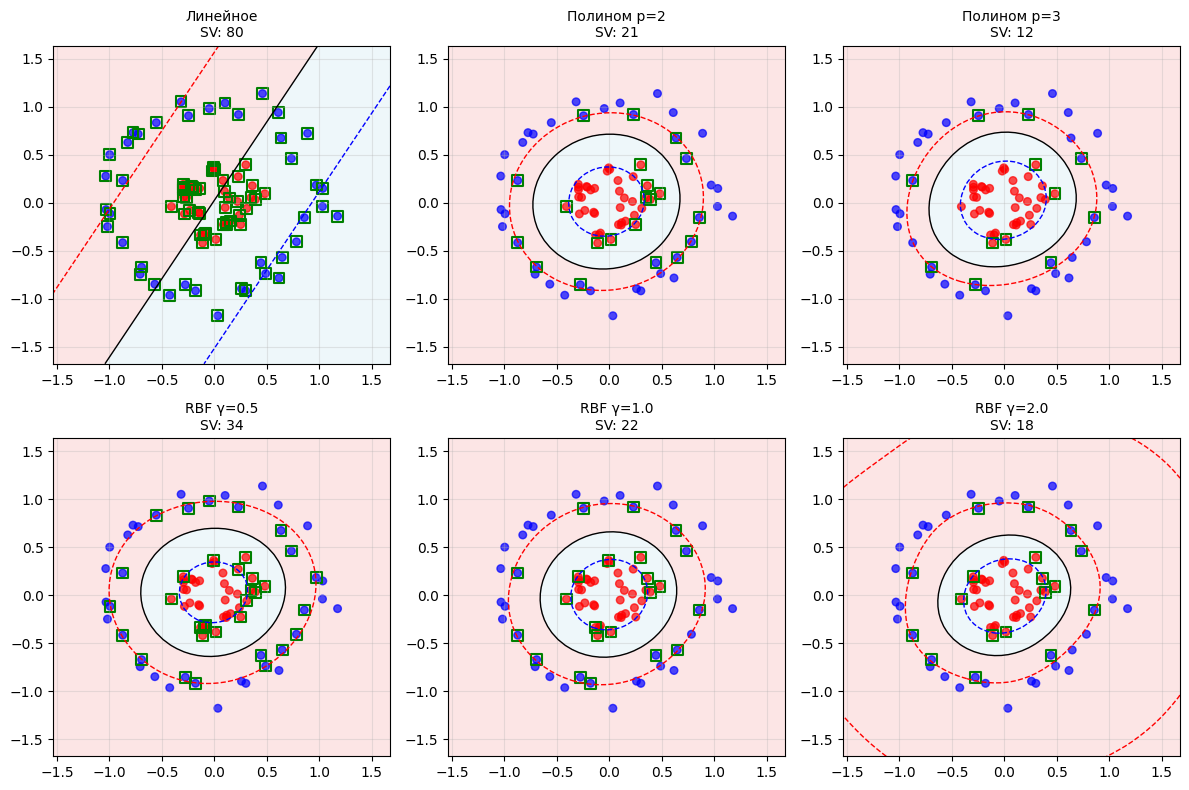

2. Полиномиальное ядро: C и степень p


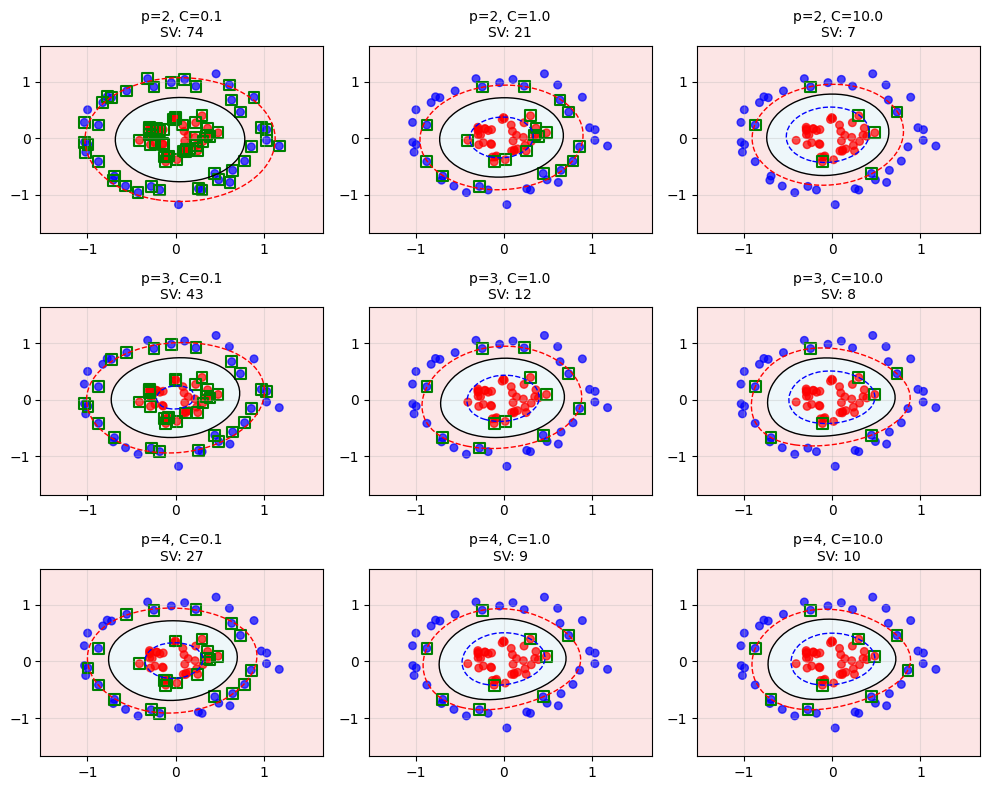

3. RBF ядро: C и γ


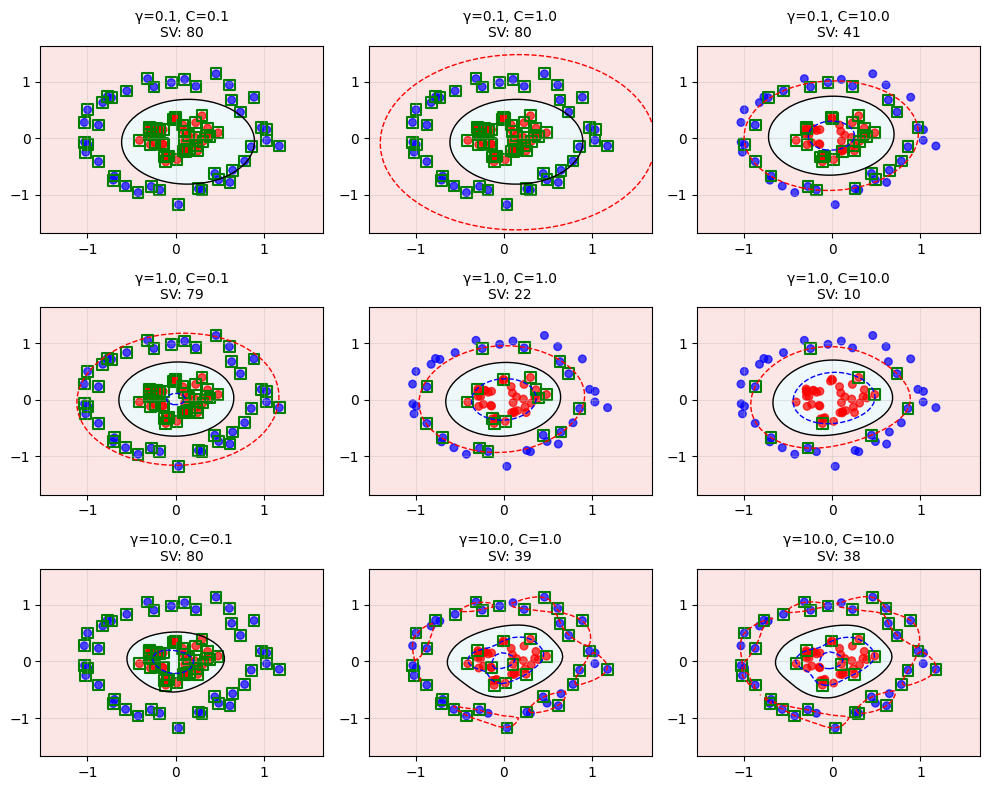


ВЫВОДЫ:
ПЕРЕОБУЧЕНИЕ: большие C (>10) + большие γ (>10) или высокие степени p (>3)
НЕДООБУЧЕНИЕ: малые C (<0.1) + малые γ (<0.1) или линейное ядро
ОПТИМАЛЬНО: C=1-10, γ=0.5-2, p=2-3


In [18]:
import numpy as np
import matplotlib.pyplot as plt
from cvxopt import matrix, solvers
from sklearn.datasets import make_circles

solvers.options['show_progress'] = False

class KernelSVM:
    def __init__(self, C=1.0, kernel='linear', degree=2, gamma=1.0):
        self.C = C
        self.kernel = kernel
        self.degree = degree
        self.gamma = gamma
        self.alpha = None
        self.b = None
        self.support_vectors = None
        self.X_train = None
        self.y_train = None

    def kernel_function(self, x1, x2):
        if self.kernel == 'linear':
            return np.dot(x1, x2)
        elif self.kernel == 'poly':
            return (np.dot(x1, x2) + 1) ** self.degree
        elif self.kernel == 'rbf':
            return np.exp(-self.gamma * np.linalg.norm(x1 - x2) ** 2)

    def fit(self, X, y):
        n_samples = X.shape[0]
        self.X_train = X
        y_transformed = y * 2 - 1
        self.y_train = y_transformed

        # Ядерная матрица
        K = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                K[i, j] = self.kernel_function(X[i], X[j])

        # QP задача с правильными типами данных
        P = matrix(np.outer(y_transformed, y_transformed) * K, tc='d')
        q = matrix(-np.ones(n_samples), tc='d')
        G = matrix(np.vstack((-np.eye(n_samples), np.eye(n_samples))), tc='d')
        h = matrix(np.hstack((np.zeros(n_samples), np.ones(n_samples) * self.C)), tc='d')
        A = matrix(y_transformed.reshape(1, -1), tc='d')
        b = matrix(0.0, tc='d')

        solution = solvers.qp(P, q, G, h, A, b)
        self.alpha = np.array(solution['x']).flatten()

        # Опорные векторы
        sv_indices = self.alpha > 1e-5
        self.support_vectors = X[sv_indices]

        # Смещение b
        if len(self.support_vectors) > 0:
            self.b = np.mean([
                y_transformed[i] - np.sum(self.alpha * y_transformed * K[:, i])
                for i in range(n_samples) if self.alpha[i] > 1e-5
            ])
        else:
            self.b = 0

        return self

    def decision_function(self, X):
        y_pred = np.zeros(X.shape[0])
        for i in range(X.shape[0]):
            kernel_vals = np.array([self.kernel_function(X[i], self.X_train[j])
                                  for j in range(len(self.X_train))])
            y_pred[i] = np.sum(self.alpha * self.y_train * kernel_vals) + self.b
        return y_pred

def plot_svm(X, y, svm, title, ax):
    # Сетка
    x_min, x_max = X[:, 0].min()-0.5, X[:, 0].max()+0.5
    y_min, y_max = X[:, 1].min()-0.5, X[:, 1].max()+0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 50),
                         np.linspace(y_min, y_max, 50))

    Z = svm.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Границы
    ax.contour(xx, yy, Z, levels=[-1, 0, 1],
               colors=['red', 'black', 'blue'], linestyles=['--', '-', '--'], linewidths=1)
    ax.contourf(xx, yy, Z, levels=[-np.inf, 0, np.inf],
                alpha=0.2, colors=['lightcoral', 'lightblue'])

    # Данные и опорные векторы
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.bwr, alpha=0.7, s=30)
    if svm.support_vectors is not None and len(svm.support_vectors) > 0:
        ax.scatter(svm.support_vectors[:, 0], svm.support_vectors[:, 1],
                  s=60, facecolors='none', edgecolors='green', marker='s', linewidth=1.5)

    ax.set_title(title, fontsize=10)
    ax.grid(True, alpha=0.3)

# Генерация данных
X, y = make_circles(n_samples=80, noise=0.1, factor=0.3, random_state=42)

# 1. Разные ядра
print("1. Разные ядерные функции")
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
kernels = [
    ('linear', 'Линейное'),
    ('poly', 'Полином p=2', 2),
    ('poly', 'Полином p=3', 3),
    ('rbf', 'RBF γ=0.5', 0.5),
    ('rbf', 'RBF γ=1.0', 1.0),
    ('rbf', 'RBF γ=2.0', 2.0)
]

for i, params in enumerate(kernels):
    ax = axes[i//3, i%3]
    if params[0] == 'linear':
        svm = KernelSVM(kernel='linear', C=1.0)
    elif params[0] == 'poly':
        svm = KernelSVM(kernel='poly', degree=params[2], C=1.0)
    else:
        svm = KernelSVM(kernel='rbf', gamma=params[2], C=1.0)

    svm.fit(X, y)
    plot_svm(X, y, svm, f"{params[1]}\nSV: {len(svm.support_vectors)}", ax)

plt.tight_layout()
plt.show()

# 2. Анализ полиномиального ядра
print("2. Полиномиальное ядро: C и степень p")
C_values = [0.1, 1.0, 10.0]
degrees = [2, 3, 4]

fig, axes = plt.subplots(len(degrees), len(C_values), figsize=(10, 8))
for i, degree in enumerate(degrees):
    for j, C in enumerate(C_values):
        svm = KernelSVM(C=C, kernel='poly', degree=degree)
        svm.fit(X, y)
        plot_svm(X, y, svm, f'p={degree}, C={C}\nSV: {len(svm.support_vectors)}', axes[i, j])

plt.tight_layout()
plt.show()

# 3. Анализ RBF ядра
print("3. RBF ядро: C и γ")
C_values = [0.1, 1.0, 10.0]
gamma_values = [0.1, 1.0, 10.0]

fig, axes = plt.subplots(len(gamma_values), len(C_values), figsize=(10, 8))
for i, gamma in enumerate(gamma_values):
    for j, C in enumerate(C_values):
        svm = KernelSVM(C=C, kernel='rbf', gamma=gamma)
        svm.fit(X, y)
        plot_svm(X, y, svm, f'γ={gamma}, C={C}\nSV: {len(svm.support_vectors)}', axes[i, j])

plt.tight_layout()
plt.show()

# Выводы
print("\nВЫВОДЫ:")
print("ПЕРЕОБУЧЕНИЕ: большие C (>10) + большие γ (>10) или высокие степени p (>3)")
print("НЕДООБУЧЕНИЕ: малые C (<0.1) + малые γ (<0.1) или линейное ядро")
print("ОПТИМАЛЬНО: C=1-10, γ=0.5-2, p=2-3")

# Примеры

Настройка вывода графиков [`Maplotlib`](http://matplotlib.org/) и импорт функций из модуля [`pylab`](http://wiki.scipy.org/PyLab).

In [ ]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['matrix']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Визуальное решение задачи квадратичного программирования

На следующем рисунке наглядно показано решение задачи QP из задания 1. Оптимизируемая функция $f(\boldsymbol x)$ показана линиями уровня, область значений недопустимых ограничениями окрашена в серый цвет.

C:\Anaconda3\lib\site-packages\matplotlib\contour.py:902: UserWarning: linewidths is ignored by contourf
  warnings.warn('linewidths is ignored by contourf')


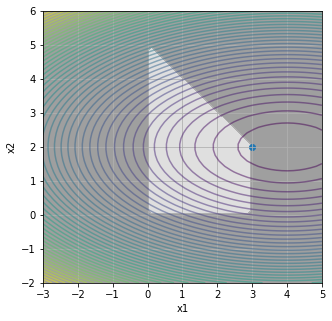

In [ ]:
x1 = linspace(-3, 5, 50)
x2 = linspace(-2, 6, 50)
xx1, xx2 = meshgrid(x1, x2)

f = -8*xx1 - 16*xx2 + xx1**2 + 4*xx2**2
constr1 = (xx1 + xx2 <= 5)
constr2 = (0 <= xx1) & (xx1 <= 3)
constr3 = (xx2 >= 0)

figure(figsize=(5, 5))
grid(True)
xlabel('x1')
ylabel('x2')

contour(x1, x2, f, 50, alpha=0.5)
contourf(x1, x2, constr1 & constr2 & constr3, 1, alpha=0.5, linewidths=4, cmap='gray')
_ = scatter([3], [2])

In [ ]:
np.array([True, False, False]) & np.array([True, False, True])

array([ True, False, False])

In [ ]:
np.logical_and(np.array([True, False, False]), np.array([True, False, True]))

array([ True, False, False])

## Установка и использование `CvxOpt`

Библиотека [`cvxopt`](http://cvxopt.org/) может быть установлена как обычный python-пакет:

In [ ]:
!pip install --upgrade --user cvxopt

  Using cached https://files.pythonhosted.org/packages/16/a0/0d090735e2639a74d6628831e02cc59284e3a3a4f5910f496fc6e435b645/cvxopt-1.2.5-cp36-cp36m-win_amd64.whl
  Using cached https://files.pythonhosted.org/packages/56/39/537cb3e4e93f1ac5085dc3b3a43cfd99d0af9b29c44fcaa99490f526b611/mkl-2019.0-py2.py3-none-win_amd64.whl


Нас будет интересовать функция [`cvxopt.solvers.qp()`](http://cvxopt.org/examples/tutorial/qp.html):

In [ ]:
from cvxopt import solvers
?solvers.qp

## Пример работы с cvxopt

In [ ]:
from cvxopt import matrix

A = matrix([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], (2,3))
print(A)
print(A.size)

[ 1.00e+00  3.00e+00  5.00e+00]
[ 2.00e+00  4.00e+00  6.00e+00]

(2, 3)


In [ ]:
G = matrix([[-1.0,0.0,-1.0,2.0,3.0],
            [0.0,-1.0,-3.0,5.0,4.0]])
print(G, G.size)

[-1.00e+00  0.00e+00]
[ 0.00e+00 -1.00e+00]
[-1.00e+00 -3.00e+00]
[ 2.00e+00  5.00e+00]
[ 3.00e+00  4.00e+00]
 (5, 2)


In [ ]:
from cvxopt import solvers

# Define QP parameters (directly)
P = matrix([[1.0,0.0],[0.0,0.0]])
q = matrix([3.0,4.0])
G = matrix([[-1.0,0.0,-1.0,2.0,3.0],[0.0,-1.0,-3.0,5.0,4.0]])
h = matrix([0.0,0.0,-15.0,100.0,80.0])
# Define QP parameters (with NumPy)
P = matrix(numpy.diag([1,0]), tc='d')
q = matrix(numpy.array([3,4]), tc='d')
G = matrix(numpy.array([[-1,0],[0,-1],[-1,-3],[2,5],[3,4]]), tc='d')
h = matrix(numpy.array([0,0,-15,100,80]), tc='d')
# Construct the QP, invoke solver
sol = solvers.qp(P,q,G,h)
# Extract optimal value and solution
print(sol['x']) # [7.13e-07, 5.00e+00]
print(sol['primal objective']) # 20.0000061731

     pcost       dcost       gap    pres   dres
 0:  1.0780e+02 -7.6366e+02  9e+02  4e-17  4e+01
 1:  9.3245e+01  9.7637e+00  8e+01  8e-17  3e+00
 2:  6.7311e+01  3.2553e+01  3e+01  8e-17  1e+00
 3:  2.6071e+01  1.5068e+01  1e+01  7e-17  7e-01
 4:  3.7092e+01  2.3152e+01  1e+01  1e-16  4e-01
 5:  2.5352e+01  1.8652e+01  7e+00  9e-17  4e-16
 6:  2.0062e+01  1.9974e+01  9e-02  7e-17  2e-16
 7:  2.0001e+01  2.0000e+01  9e-04  8e-17  2e-16
 8:  2.0000e+01  2.0000e+01  9e-06  1e-16  2e-16
Optimal solution found.
[ 7.13e-07]
[ 5.00e+00]

20.00000617311241


In [ ]:
sol

{'x': <2x1 matrix, tc='d'>,
 'y': <0x1 matrix, tc='d'>,
 's': <5x1 matrix, tc='d'>,
 'z': <5x1 matrix, tc='d'>,
 'status': 'optimal',
 'gap': 8.788553731701274e-06,
 'relative gap': 4.3942774404993765e-07,
 'primal objective': 20.00000617311241,
 'dual objective': 19.99999738455868,
 'primal infeasibility': 1.1710307819972547e-16,
 'dual infeasibility': 1.9860273225978186e-16,
 'primal slack': 7.131816408857108e-07,
 'dual slack': 1.50695110360481e-08,
 'iterations': 8}

In [ ]:
print(sol['x'])

[ 7.13e-07]
[ 5.00e+00]



Матрицы задач квадратичного программирования как правило разрежены, лучше использовать матричные операции над разреженными матрицами при реализации SVM.
[Разреженные и плотные матрицы](http://abel.ee.ucla.edu/cvxopt/userguide/matrices.html)

## Генерация случайной выборки для задачи классификации

В `SciKit-Learn` есть функция генерации случайных выборок для классификации [`sklearn.datasets.make_classification()`](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html). Для того чтобы выборки не менялись при перезапуске ноутбука, используйте параметр `random_state`.

In [ ]:
from sklearn.datasets import make_classification

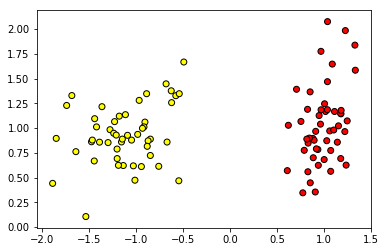

In [ ]:
X, y = make_classification(n_samples=100, n_features=2, n_redundant=0, n_clusters_per_class=1, random_state=1)
scatter(X[:, 0], X[:, 1], c=y, cmap='autumn', edgecolor='black')

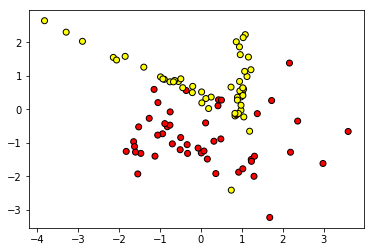

In [ ]:
X, y = make_classification(n_samples=100, n_features=2, n_redundant=0, n_clusters_per_class=2, random_state=2)
scatter(X[:, 0], X[:, 1], c=y, cmap='autumn', edgecolor='black')

## Визуализация решающего правила

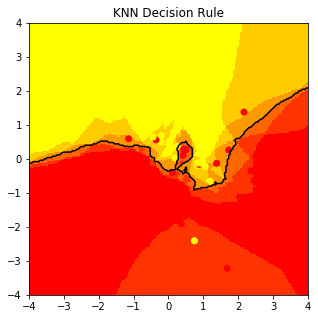

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=5)
model.fit(X, y)

figure(figsize=(5, 5))
scatter(X[:, 0], X[:, 1], c=y, cmap='autumn')

xvals = linspace(-4, 4, 200)
yvals = linspace(-4, 4, 200)

xx, yy = np.meshgrid(xvals, yvals)
zz = np.reshape(model.predict_proba(c_[xx.ravel(), yy.ravel()])[:, 1], xx.shape)

# Цветной фон, соответствующий значению решающего правила
pcolormesh(xx, yy, zz, cmap='autumn', zorder=0)

# Линия уровня, соответствующая значению 0.5
contour(xx, yy, zz, levels=(0.5,), colors='k', linewidths=1.5, zorder=1)

xlim([-4, 4])
ylim([-4, 4])
_ = title('KNN Decision Rule')

## Реализация собственной модели для SciKit-Learn

В заданиях 2 и 3 требуется самостоятельно реализовать алгоритм обучения классификатора. Для того чтобы ваш алгоритм можно было использовать различными компонентами библиотеки SciKit-Learn (оценка качества, подбор параметров, композиции и т.д.) нужно всего лишь [реализовать интерфейс `BaseEstimator`](http://scikit-learn.org/stable/developers/#estimators).

In [ ]:
from sklearn.base import BaseEstimator

class LinearSVM(BaseEstimator):
    def __init__(self, C, transform=None):
        self.C = C
        self.transform = transform

    def fit(self, X, y):
        """
        Функция обучения модели.
        """
        dim = X.shape[1]
        self.weights_ = empty(dim)
        self.bias_ = 0
        raise NotImplementedError()

    def predict_proba(self, X):
        return (dot(X, self.weights_) + self.bias_).flatten()

    def predict(self, X):
        return sign(self.predict_proba(X))

In [ ]:
from sklearn.base import BaseEstimator

class DualSVM(BaseEstimator):
    def __init__(self, C, kernel=None):
        self.C = C
        self.kernel = kernel

    def fit(self, X, y):
        """
        Функция обучения модели.
        """
        self.dim = X.shape[1]
        self.N = X.shape[0]
        self.alpha_ = empty(self.N)
        self.bias_ = 0
        raise NotImplementedError()

    def predict_proba(self, X):
        pass

    def predict(self, X):
        pass